# GAIT-CYCLE

In [4]:
import numpy as np
from skimage.io import imread, imshow
from skimage.io import imread_collection
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import os
import skimage
from PIL import Image
from skimage.transform import resize
import cv2

In [5]:
files = os.listdir("C:/Users/radhi/Downloads/TreadmillDatasetA/TreadmillDatasetA/00001/gallery_4km/")
images=[imread('C:/Users/radhi/Downloads/TreadmillDatasetA/TreadmillDatasetA/00001/gallery_4km/'+f) for f in files]

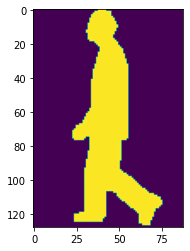

In [6]:
plt.imshow(images[0])

In [7]:
def mass_center(img,is_round=True):
    Y = img.mean(axis=1)
    X = img.mean(axis=0)
    Y_ = np.sum(np.arange(Y.shape[0]) * Y)/np.sum(Y)
    X_ = np.sum(np.arange(X.shape[0]) * X)/np.sum(X)
    if is_round:
        return int(round(X_)),int(round(Y_))
    return X_,Y_

def image_extract(img,newsize):
    x_s = np.where(img.mean(axis=0)!=0)[0].min()
    x_e = np.where(img.mean(axis=0)!=0)[0].max()
    
    y_s = np.where(img.mean(axis=1)!=0)[0].min()
    y_e = np.where(img.mean(axis=1)!=0)[0].max()
    
    x_c,_ = mass_center(img)
#     x_c = (x_s+x_e)//2
    x_s = x_c-newsize[1]//2
    x_e = x_c+newsize[1]//2
    img = img[y_s:y_e,x_s if x_s>0 else 0:x_e if x_e<img.shape[1] else img.shape[1]]
    return skimage.transform.resize(img,newsize)


In [8]:
images = [image_extract(i,(128,64)) for i in images]

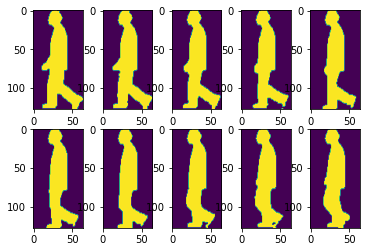

In [9]:
plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
plt.show()

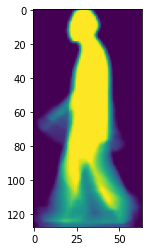

In [10]:
gei = np.mean(images,axis=0)
plt.imshow(gei)
plt.show()

In [11]:
plt.savefig('gei.jpg')

<Figure size 432x288 with 0 Axes>

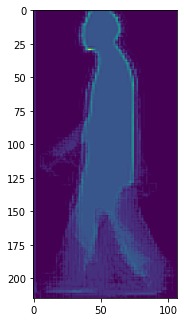

In [16]:
# Grayscale
def BGR2GRAY(img):
	# Grayscale
	gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
	return gray

# Gabor Filter
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
	# get half size
	d = K_size // 2

	# prepare kernel
	gabor = np.zeros((K_size, K_size), dtype=np.float32)

	# each value
	for y in range(K_size):
		for x in range(K_size):
			# distance from center
			px = x - d
			py = y - d

			# degree -> radian
			theta = angle / 180. * np.pi

			# get kernel x
			_x = np.cos(theta) * px + np.sin(theta) * py

			# get kernel y
			_y = -np.sin(theta) * px + np.cos(theta) * py

			# fill kernel
			gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

	# kernel normalization
	gabor /= np.sum(np.abs(gabor))

	return gabor


# Use Gabor filter to act on the image
def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)
        
    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


# Use 6 Gabor filters with different angles to perform feature extraction on the image
def Gabor_process(img):
    # get shape
    H, W, _ = img.shape

    # gray scale
    gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    #As = [0, 45, 90, 135]
    As = [0,30,60,90,120,150]

    # prepare pyplot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
        # gabor filtering
        _out = Gabor_filtering(gray, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)

        # add gabor filtered image
        out += _out

    # scale normalization
    out = out / out.max() * 255
    out = out.astype(np.uint8)

    return out


# Read image
img = cv2.imread("C:/Users/radhi/Documents/gAIt/gei/1.png").astype(np.float32)

# gabor process
out = Gabor_process(img)

cv2.imwrite("out.jpg", out)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(out)
plt.show()